In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import ParameterGrid


In [2]:
# Load the dataset
data_path = '../data/events.csv'  # Update the path to your file
data = pd.read_csv(data_path)

In [3]:
# Filter data to include only rows with valid shot_place
shots_data = data.dropna(subset=['shot_place'])

In [4]:
# Ensure at least 1000 samples
if len(shots_data) < 1000:
    raise ValueError("Dataset must have at least 1000 samples after filtering.")

In [5]:
# Reduce the dataset size for quicker execution (e.g., 1000 samples)
shots_data = shots_data.sample(n=1000, random_state=42)
print("Reduced dataset shape:", shots_data.shape)

Reduced dataset shape: (1000, 22)


In [6]:
# Feature Engineering: Add derived features
shots_data['time_since_last_event'] = shots_data.groupby('id_odsp')['time'].diff().fillna(0)

In [7]:
# Define features to include
categorical_columns = ['side', 'bodypart', 'assist_method', 'situation', 'fast_break', 'event_team', 'opponent']
numerical_columns = ['time', 'shot_outcome', 'location', 'is_goal', 'time_since_last_event']
text_column = 'text'

In [8]:
# Handle missing values in numerical columns
shots_data[numerical_columns] = shots_data[numerical_columns].fillna(shots_data[numerical_columns].mean())
print("Data after filling missing values:")
print(shots_data.head())

Data after filling missing values:
          id_odsp    id_event  sort_order  time  \
763533  MHZSkeoD/  MHZSkeoD88          88    84   
143031  CSIVz9Rt/  CSIVz9Rt60          60    77   
901230  AT8BU3Vt/  AT8BU3Vt97          97    87   
127033  dfsta8kI/  dfsta8kI38          38    39   
659151  Qa1FLFwr/  Qa1FLFwr20          20    29   

                                                     text  event_type  \
763533  Goal!  Nantes 2, Bordeaux 1. Cheick DiabatA© (...           1   
143031  Goal!  FC Nurnberg 1, Bayer Leverkusen 3. Andr...           1   
901230  Attempt blocked. Alexandre Mendy (Guingamp) ri...           1   
127033  Attempt blocked. Alejandro Alfaro (Mallorca) r...           1   
659151  Attempt missed. Ola Toivonen (Rennes) right fo...           1   

        event_type2  side        event_team          opponent  ... player_out  \
763533         12.0     2          Bordeaux            Nantes  ...        NaN   
143031         12.0     2  Bayer Leverkusen          Nurn

In [9]:
# Balance the dataset using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(shots_data, shots_data['shot_place'])
shots_data = pd.DataFrame(X_balanced, columns=shots_data.columns)
print("Balanced dataset shape:", shots_data.shape)

Balanced dataset shape: (2873, 23)


In [10]:
# Preprocessing: One-hot encode categorical, scale numerical, and extract text features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns),
        ('text', TfidfVectorizer(max_features=50), text_column)
    ],
    remainder='drop'
)


In [11]:
# Apply preprocessing
processed_data = preprocessor.fit_transform(shots_data).toarray()
print("Processed data shape:", processed_data.shape)

Processed data shape: (2873, 341)


In [13]:
# Hyperparameter tuning for OPTICS
param_grid = {
    'min_samples': [5, 10, 20],
    'xi': [0.05, 0.1, 0.2],
    'metric': ['euclidean', 'cosine']
}

In [14]:
best_score = -1
best_params = None
best_labels = None

In [15]:
for params in ParameterGrid(param_grid):
    optics_model = OPTICS(**params)
    optics_model.fit(processed_data)
    labels = optics_model.labels_
    if len(set(labels)) > 1:
        score = silhouette_score(processed_data, labels, metric='euclidean')
        if score > best_score:
            best_score = score
            best_params = params
            best_labels = labels

c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\sklearn\cluster\_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\sklearn\cluster\_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\sklearn\cluster\_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\sklearn\cluster\_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\sklearn\cluster\_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot

In [16]:
print("Best parameters:", best_params)
print("Best silhouette score:", best_score)

Best parameters: {'metric': 'cosine', 'min_samples': 5, 'xi': 0.05}
Best silhouette score: 0.3482742897723422


In [17]:
# Use the best model
optics_model = OPTICS(**best_params)
optics_model.fit(processed_data)
labels = optics_model.labels_
shots_data['cluster'] = labels
print("Cluster labels:", labels[:10])

Cluster labels: [  0  19  -1  -1  -1  -1 195  -1  91  87]


c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\sklearn\cluster\_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [18]:
# Evaluate clustering
unique_labels = set(labels)
print(f"Clusters found: {unique_labels}")
if len(unique_labels) > 1:
    silhouette = silhouette_score(processed_data, labels, metric='euclidean')
    davies_bouldin = davies_bouldin_score(processed_data, labels)
    calinski_harabasz = calinski_harabasz_score(processed_data, labels)
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")
else:
    print("Clustering metrics cannot be computed with fewer than 2 clusters.")

Clusters found: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, -1}
Silhouette Score: 0.3483
Davies-Bouldin Index: 1.1776
Calinski-Haraba

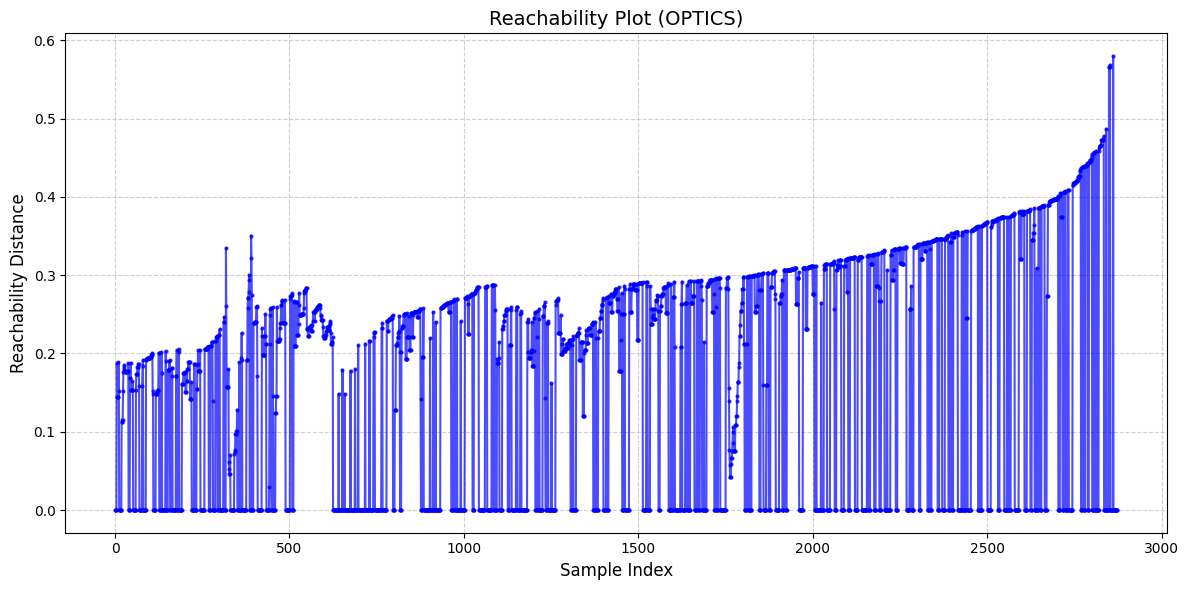

In [19]:
# Visualize the reachability plot
plt.figure(figsize=(12, 6))
space = range(processed_data.shape[0])
reachability = optics_model.reachability_[optics_model.ordering_]
plt.plot(space, reachability, marker='o', markersize=2, color='blue', alpha=0.7)
plt.title('Reachability Plot (OPTICS)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Reachability Distance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [20]:
# Analyze the clustering results
unique_labels = set(labels)
print(f"Clusters found: {unique_labels}")

Clusters found: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, -1}


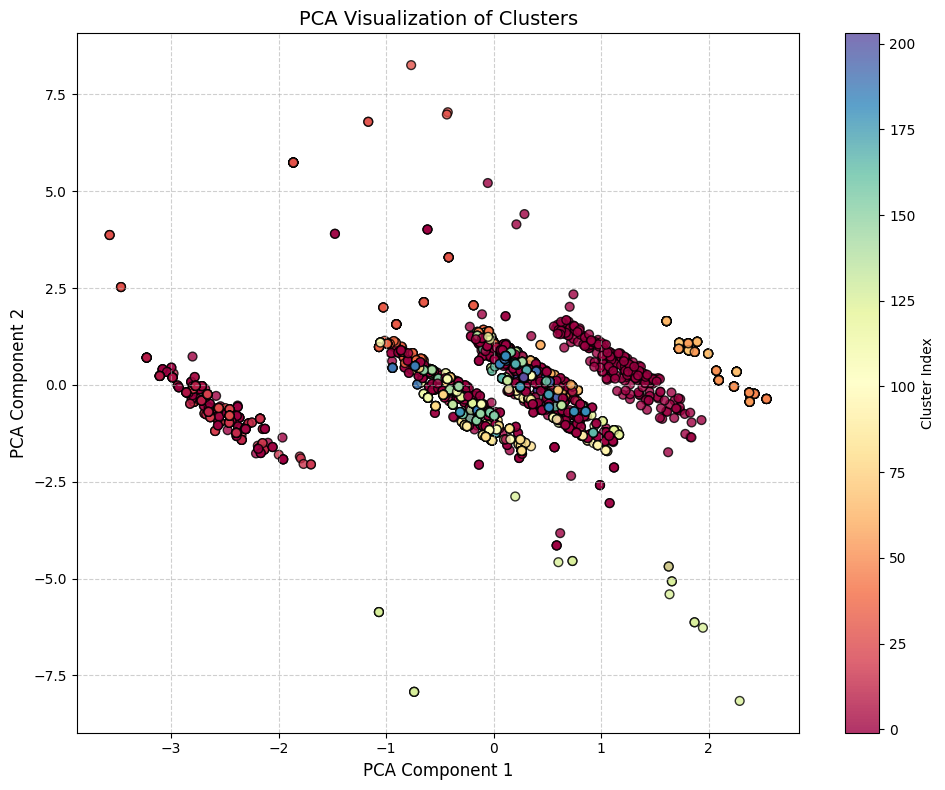

In [21]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(processed_data)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_data[:, 0], 
    pca_data[:, 1], 
    c=labels, 
    cmap='Spectral', 
    s=40, 
    edgecolor='k', 
    alpha=0.8
)
plt.title('PCA Visualization of Clusters', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(scatter, label="Cluster Index")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [22]:
# Analyze shot_place proportions within each cluster
cluster_proportions = shots_data.groupby('cluster')['shot_place'].value_counts(normalize=True).unstack(fill_value=0)
print("Proportion of shot_place in each cluster:")
print(cluster_proportions)

Proportion of shot_place in each cluster:
shot_place      1.0       2.0       3.0       4.0       5.0      6.0   7.0   \
cluster                                                                       
-1          0.009752  0.193262  0.094858  0.110816  0.110816  0.10461   0.0   
 0          0.000000  0.000000  1.000000  0.000000  0.000000  0.00000   0.0   
 1          0.000000  0.000000  0.000000  1.000000  0.000000  0.00000   0.0   
 2          0.000000  0.000000  0.285714  0.142857  0.000000  0.00000   0.0   
 3          0.000000  0.000000  0.000000  0.285714  0.714286  0.00000   0.0   
...              ...       ...       ...       ...       ...      ...   ...   
 199        1.000000  0.000000  0.000000  0.000000  0.000000  0.00000   0.0   
 200        1.000000  0.000000  0.000000  0.000000  0.000000  0.00000   0.0   
 201        1.000000  0.000000  0.000000  0.000000  0.000000  0.00000   0.0   
 202        1.000000  0.000000  0.000000  0.000000  0.000000  0.00000   0.0   
 203      

In [23]:
# Assign shot_place label to each cluster based on majority vote
cluster_to_label = cluster_proportions.idxmax(axis=1)
print("Cluster-to-shot_place mapping:")
print(cluster_to_label)

Cluster-to-shot_place mapping:
cluster
-1       2.0
 0       3.0
 1       4.0
 2      12.0
 3       5.0
        ... 
 199     1.0
 200     1.0
 201     1.0
 202     1.0
 203    13.0
Length: 205, dtype: float64


In [24]:
# Map the predicted labels back to the dataset
shots_data['predicted_shot_place'] = shots_data['cluster'].map(cluster_to_label)

In [25]:
from sklearn.metrics import accuracy_score

# Compute accuracy
valid_rows = shots_data['predicted_shot_place'].notna()
accuracy = accuracy_score(shots_data.loc[valid_rows, 'shot_place'], shots_data.loc[valid_rows, 'predicted_shot_place'])
print(f"Accuracy of clustering-based shot_place prediction: {accuracy:.4f}")

Accuracy of clustering-based shot_place prediction: 0.6216


In [26]:
# Save the final dataset
shots_data.to_csv('clustered_shots_with_predictions.csv', index=False)
print("Clustered data with predictions saved to 'clustered_shots_with_predictions.csv'.")

Clustered data with predictions saved to 'clustered_shots_with_predictions.csv'.


In [27]:
# For curiosity, check the distribution of shot_place after balancing
print("Shot place distribution after balancing:")
print(shots_data['shot_place'].value_counts())

Shot place distribution after balancing:
shot_place
3.0     221
2.0     221
9.0     221
10.0    221
8.0     221
5.0     221
4.0     221
6.0     221
1.0     221
12.0    221
7.0     221
13.0    221
11.0    221
Name: count, dtype: int64


C:\Users\stoic\AppData\Local\Temp\ipykernel_23728\2120771724.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster_aggregated', data=shots_data, palette='viridis', order=[-2] + list(top_clusters))


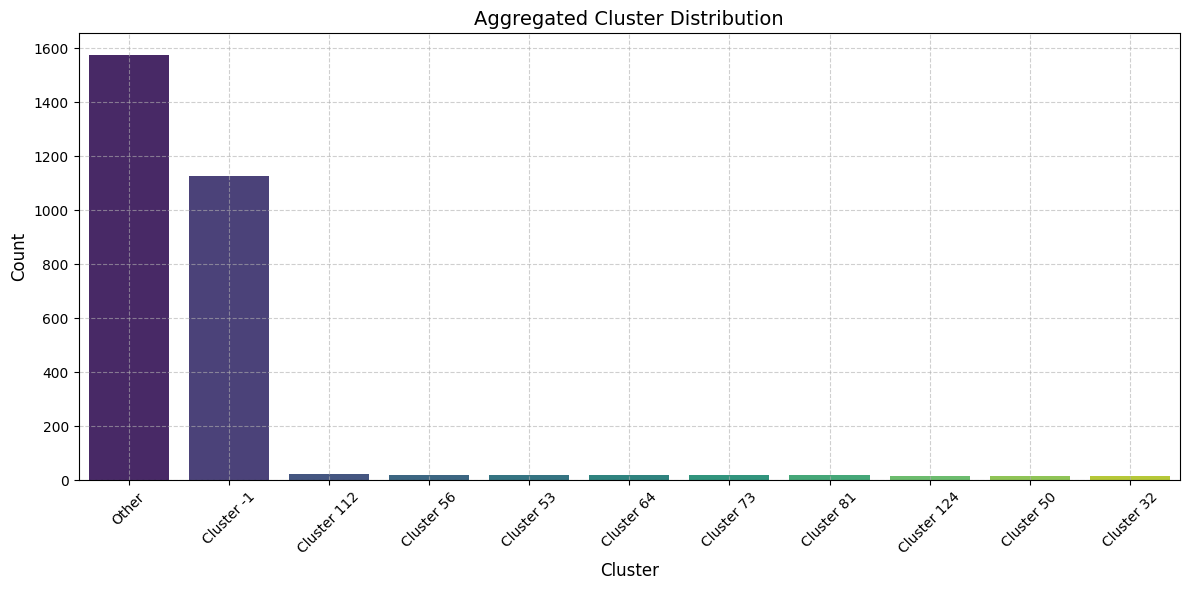

In [28]:
# Aggregate smaller clusters into an "Other" category
cluster_counts = shots_data['cluster'].value_counts()
top_clusters = cluster_counts.head(10).index
shots_data['cluster_aggregated'] = shots_data['cluster'].apply(lambda x: x if x in top_clusters else -2)

# Plot the aggregated cluster distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='cluster_aggregated', data=shots_data, palette='viridis', order=[-2] + list(top_clusters))
plt.title('Aggregated Cluster Distribution', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=range(len(top_clusters) + 1), labels=['Other'] + [f'Cluster {i}' for i in top_clusters], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [29]:
# Feature Importance (using PCA loadings)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
feature_names = numerical_columns + list(preprocessor.named_transformers_['cat'].get_feature_names_out()) + ['text_feature_' + str(i) for i in range(50)]
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=feature_names)
loadings_df['abs_PC1'] = loadings_df['PC1'].abs()
loadings_df['abs_PC2'] = loadings_df['PC2'].abs()
loadings_df = loadings_df.sort_values(by='abs_PC1', ascending=False)
print("Top 10 features contributing to PC1:")
print(loadings_df.head(10))

Top 10 features contributing to PC1:
                            PC1       PC2   abs_PC1   abs_PC2
shot_outcome           0.789232  0.233777  0.789232  0.233777
is_goal               -0.770721 -0.218381  0.770721  0.218381
time                  -0.324200  0.513904  0.324200  0.513904
location              -0.202321  0.488023  0.202321  0.488023
time_since_last_event -0.154529  0.722241  0.154529  0.722241
text_feature_22       -0.095163 -0.027095  0.095163  0.027095
assist_method_1        0.093301  0.101831  0.093301  0.101831
text_feature_15       -0.061625 -0.022632  0.061625  0.022632
text_feature_25        0.060880  0.015719  0.060880  0.015719
text_feature_6         0.058177  0.036303  0.058177  0.036303


C:\Users\stoic\AppData\Local\Temp\ipykernel_23728\1433264713.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loadings_df['abs_PC1'][:10], y=loadings_df.index[:10], palette='viridis')


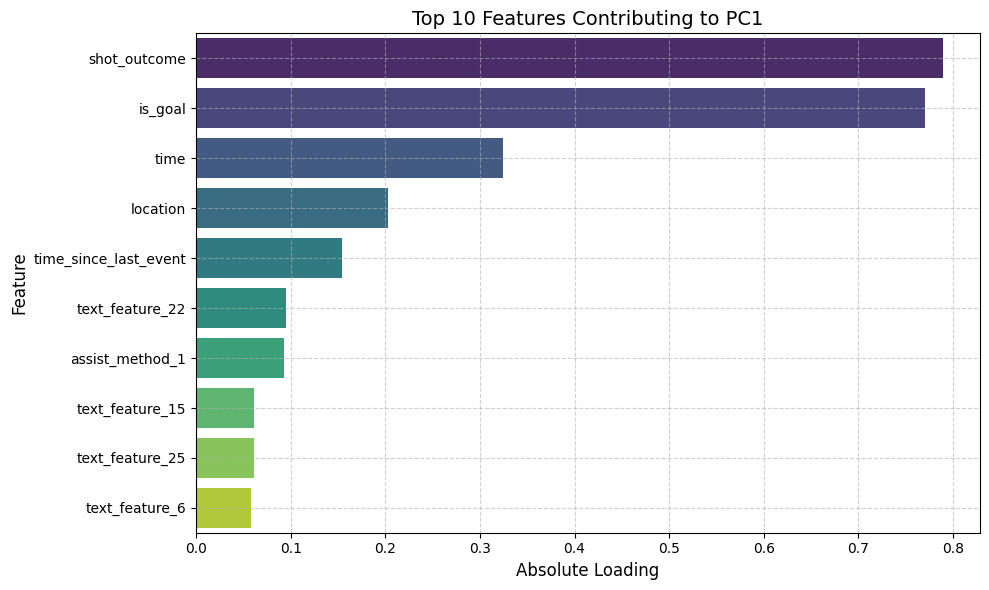

In [30]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=loadings_df['abs_PC1'][:10], y=loadings_df.index[:10], palette='viridis')
plt.title('Top 10 Features Contributing to PC1', fontsize=14)
plt.xlabel('Absolute Loading', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

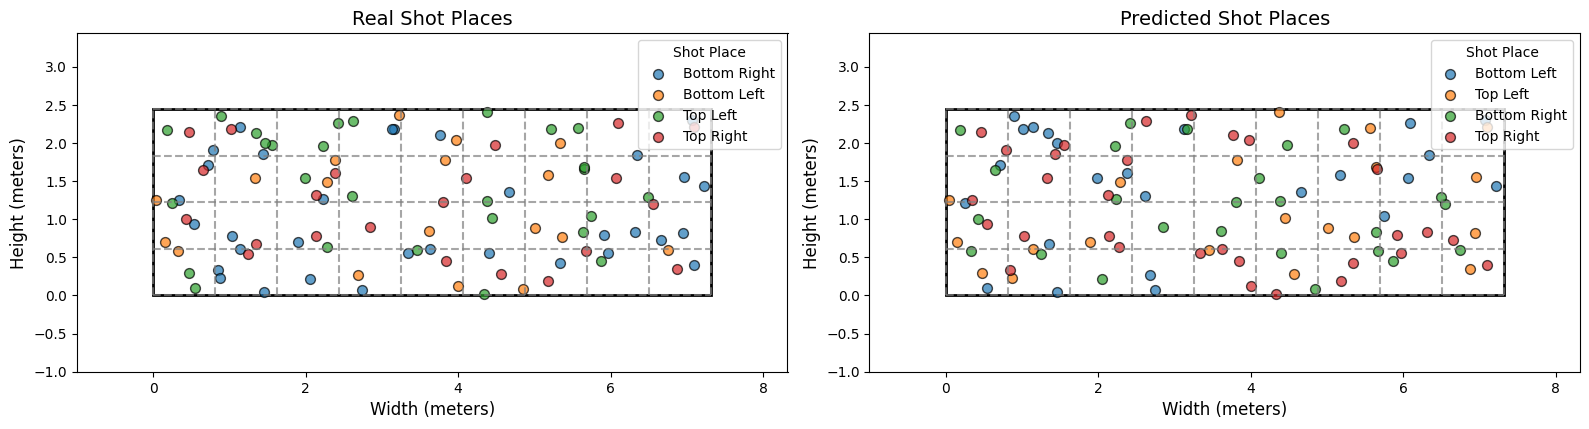

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

# Function to draw a soccer goal and plot the shot placements
def plot_goal_with_shots(data, label_column, title, ax):
    # Draw the goal
    goal_width = 7.32  # Goal width in meters
    goal_height = 2.44  # Goal height in meters

    # Add a rectangle for the goal frame
    goal_frame = patches.Rectangle((0, 0), goal_width, goal_height, edgecolor='black', facecolor='none', lw=2)
    ax.add_patch(goal_frame)

    # Add the goal net (grid)
    for x in np.linspace(0, goal_width, 10):
        ax.plot([x, x], [0, goal_height], color='gray', linestyle='--', alpha=0.7)
    for y in np.linspace(0, goal_height, 5):
        ax.plot([0, goal_width], [y, y], color='gray', linestyle='--', alpha=0.7)

    # Plot the shots
    for category, color in zip(data[label_column].unique(), plt.cm.tab10.colors):
        category_data = data[data[label_column] == category]
        x_coords = category_data['shot_x']
        y_coords = category_data['shot_y']
        ax.scatter(x_coords, y_coords, label=f"{category}", alpha=0.7, edgecolor='k', s=50, color=color)

    ax.set_xlim(-1, goal_width + 1)
    ax.set_ylim(-1, goal_height + 1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Width (meters)', fontsize=12)
    ax.set_ylabel('Height (meters)', fontsize=12)
    ax.legend(loc='upper right', title='Shot Place', fontsize=10)

# Simulate data (update with actual data)
# Shots data should include shot_x (horizontal position) and shot_y (vertical position)
# along with the real and predicted shot_place labels.
np.random.seed(42)
num_samples = 100
shots_data = pd.DataFrame({
    'shot_x': np.random.uniform(0, 7.32, num_samples),  # Random x coordinates within goal width
    'shot_y': np.random.uniform(0, 2.44, num_samples),  # Random y coordinates within goal height
    'shot_place': np.random.choice(['Top Left', 'Top Right', 'Bottom Left', 'Bottom Right'], num_samples),
    'predicted_shot_place': np.random.choice(['Top Left', 'Top Right', 'Bottom Left', 'Bottom Right'], num_samples)
})

# Create the figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot real shot labels
plot_goal_with_shots(shots_data, label_column='shot_place', title='Real Shot Places', ax=axes[0])

# Plot predicted shot labels
plot_goal_with_shots(shots_data, label_column='predicted_shot_place', title='Predicted Shot Places', ax=axes[1])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np

# Mapping of shot places to goal coordinates
shot_place_map = {
    1: "Bit too high", 2: "Blocked", 3: "Bottom left corner", 4: "Bottom right corner", 5: "Centre of the goal",
    6: "High and wide", 7: "Hits the bar", 8: "Misses to the left", 9: "Misses to the right", 10: "Too high",
    11: "Top centre of the goal", 12: "Top left corner", 13: "Top right corner"
}

# Define goal regions (intervals for plotting shots)
goal_regions = {
    "Bottom left corner": ((0, 2.44 / 3), (0, 7.32 / 3)),
    "Bottom right corner": ((0, 2.44 / 3), (7.32 * 2 / 3, 7.32)),
    "Centre of the goal": ((2.44 / 3, 2.44 * 2 / 3), (7.32 / 3, 7.32 * 2 / 3)),
    "Top left corner": ((2.44 * 2 / 3, 2.44), (0, 7.32 / 3)),
    "Top right corner": ((2.44 * 2 / 3, 2.44), (7.32 * 2 / 3, 7.32)),
    "Top centre of the goal": ((2.44 * 2 / 3, 2.44), (7.32 / 3, 7.32 * 2 / 3)),
    "Misses to the left": ((0, 2.44), (-1, 0)),
    "Misses to the right": ((0, 2.44), (7.32, 7.32 + 1)),
    "Too high": ((2.44, 2.44 + 1), (0, 7.32)),
    "Bit too high": ((2.44, 2.44 + 0.5), (7.32 / 3, 7.32 * 2 / 3)),
    "High and wide": ((2.44, 2.44 + 1), (-1, 0)),
    "Hits the bar": ((2.44 - 0.1, 2.44 + 0.1), (7.32 / 3, 7.32 * 2 / 3)),
    "Blocked": ((0, 2.44 / 2), (7.32 / 3, 7.32 * 2 / 3)),
}

In [55]:
# Function to draw a soccer goal and plot the shots
def plot_goal_with_clusters(data, shot_place_column, title, ax):
    # Draw the goal
    goal_width = 7.32  # Goal width in meters
    goal_height = 2.44  # Goal height in meters

    # Add a rectangle for the goal frame
    goal_frame = patches.Rectangle((0, 0), goal_width, goal_height, edgecolor='black', facecolor='none', lw=2)
    ax.add_patch(goal_frame)

    # Add the goal net (grid)
    for x in np.linspace(0, goal_width, 10):
        ax.plot([x, x], [0, goal_height], color='gray', linestyle='--', alpha=0.7)
    for y in np.linspace(0, goal_height, 5):
        ax.plot([0, goal_width], [y, y], color='gray', linestyle='--', alpha=0.7)

    # Plot the shots for each shot place
    for shot_place_value in data[shot_place_column].unique():
        # Convert numeric shot_place_value to corresponding string
        shot_place = shot_place_map.get(int(shot_place_value), "Unknown")  # Handle potential missing keys
        if shot_place in goal_regions:
            y_range, x_range = goal_regions[shot_place]
            print(f"Plotting shots for: {shot_place}")
            shot_data = data[data[shot_place_column] == shot_place_value]
            x_coords = np.random.uniform(x_range[0], x_range[1], len(shot_data))
            y_coords = np.random.uniform(y_range[0], y_range[1], len(shot_data))
            color = plt.cm.tab10(hash(shot_place) % 10)  # Ensure consistent color mapping
            ax.scatter(x_coords, y_coords, label=f"{shot_place}", alpha=0.7, edgecolor='k', s=50, color=color)

    ax.set_xlim(-1, goal_width + 1)
    ax.set_ylim(-1, goal_height + 1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Width (meters)', fontsize=12)
    ax.set_ylabel('Height (meters)', fontsize=12)

Plotting shots for: Bottom left corner
Plotting shots for: Blocked
Plotting shots for: Too high
Plotting shots for: Misses to the left
Plotting shots for: Bottom right corner
Plotting shots for: Centre of the goal
Plotting shots for: Bit too high
Plotting shots for: Top left corner
Plotting shots for: High and wide
Plotting shots for: Hits the bar
Plotting shots for: Top right corner
Plotting shots for: Top centre of the goal
Plotting shots for: Misses to the right
Plotting shots for: Bottom left corner
Plotting shots for: Blocked
Plotting shots for: Misses to the right
Plotting shots for: Too high
Plotting shots for: Misses to the left
Plotting shots for: Centre of the goal
Plotting shots for: Bottom right corner
Plotting shots for: High and wide
Plotting shots for: Bit too high
Plotting shots for: Top left corner
Plotting shots for: Hits the bar
Plotting shots for: Top right corner
Plotting shots for: Top centre of the goal


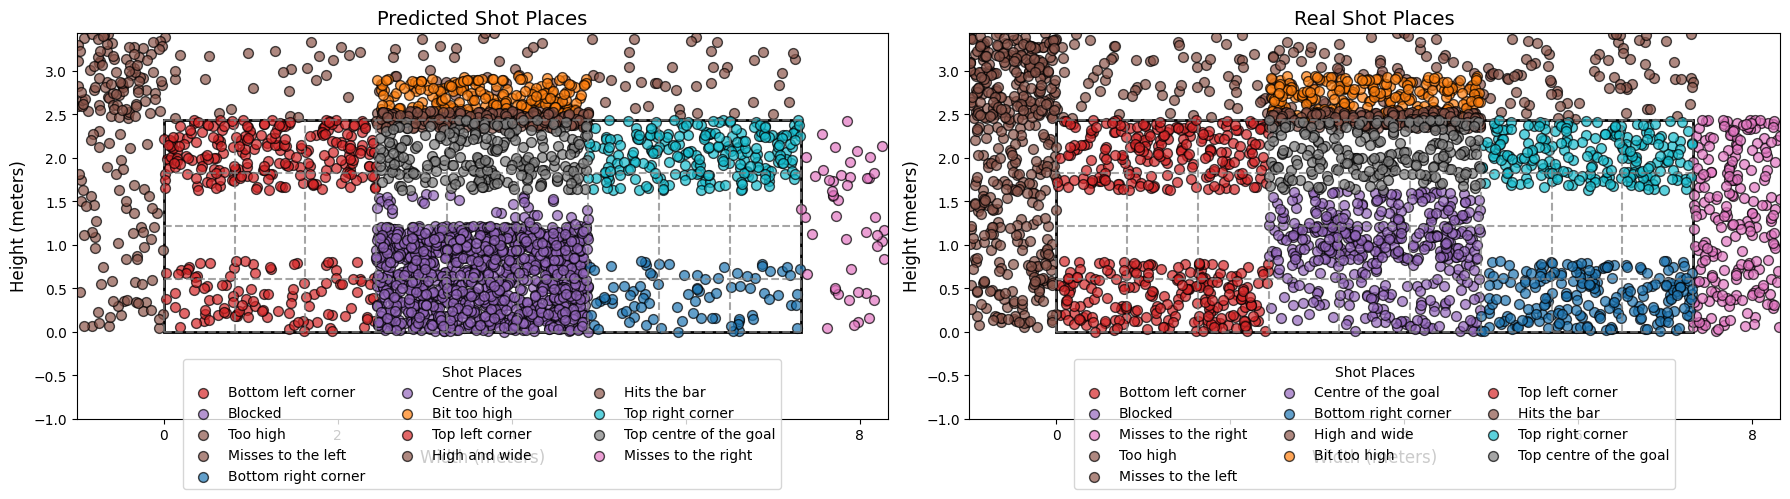

In [56]:
# Load the dataset with predictions and real labels
data_path = 'clustered_shots_with_predictions.csv'  # Path to the dataset
shots_data = pd.read_csv(data_path)

# Create the figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot predicted shot labels
plot_goal_with_clusters(shots_data, shot_place_column='predicted_shot_place', title='Predicted Shot Places', ax=axes[0])

# Plot real shot labels
plot_goal_with_clusters(shots_data, shot_place_column='shot_place', title='Real Shot Places', ax=axes[1])

# Adjust the legend placement for better visualization
for ax in axes:
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), title='Shot Places', fontsize=10, ncol=3, frameon=True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

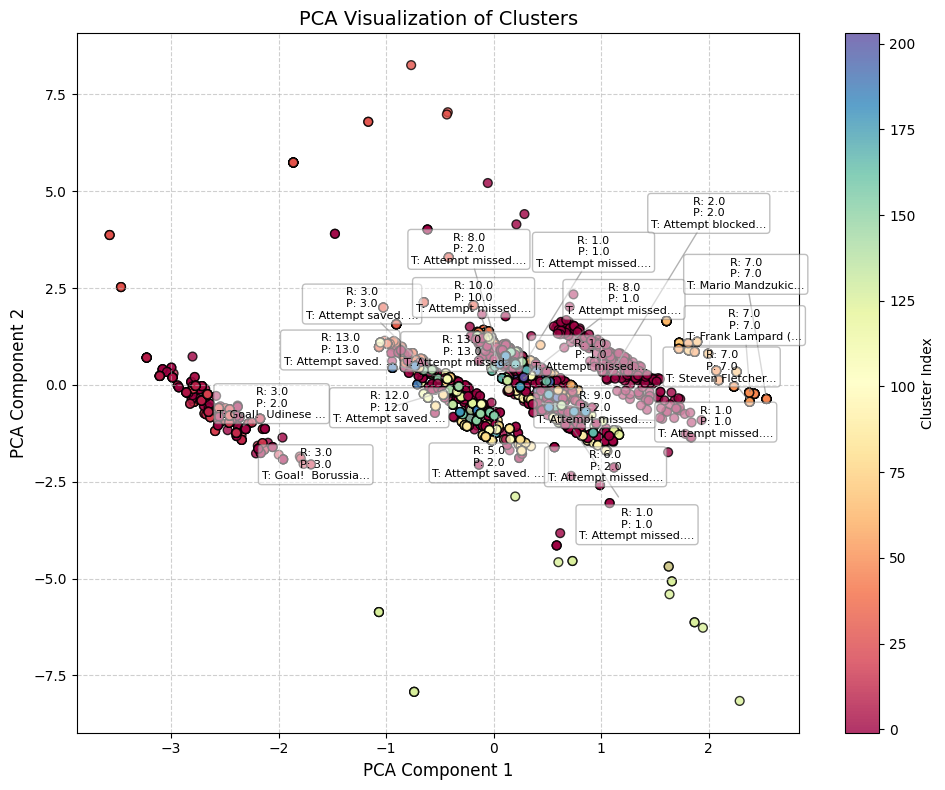

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from adjustText import adjust_text

# Assuming processed_data and labels are already defined
# Add real and predicted shot_place columns to shots_data
shots_data['pca_x'] = None
shots_data['pca_y'] = None

# Perform PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(processed_data)
shots_data['pca_x'] = pca_data[:, 0]
shots_data['pca_y'] = pca_data[:, 1]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_data[:, 0], 
    pca_data[:, 1], 
    c=labels, 
    cmap='Spectral', 
    s=40, 
    edgecolor='k', 
    alpha=0.8
)

# Add text annotations for a random sample of points with adjustText
texts = []
random_sample = shots_data.sample(n=20, random_state=42)
for i, row in random_sample.iterrows():
    truncated_text = (row['text'][:15] + '...') if len(row['text']) > 15 else row['text']
    texts.append(plt.text(
        row['pca_x'], 
        row['pca_y'], 
        f"R: {row['shot_place']}\nP: {row['predicted_shot_place']}\nT: {truncated_text}", 
        fontsize=8, 
        ha='center', 
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray', boxstyle='round,pad=0.3')
    ))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', alpha=0.6))

plt.title('PCA Visualization of Clusters', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(scatter, label="Cluster Index")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
